# Capstone Project 2 — Semiconductor Manufacturing Process Classification

**Domain:** Semiconductor manufacturing process  
**Objective:** Build a classifier to predict Pass/Fail yield of a process entity using signal data from sensors in semiconductor manufacturing.

**Dataset:** `signal-data.csv`  
- **Rows:** ~1567  
- **Columns:** ~591 features + target  
- **Target:** `Pass/Fail` column (`-1` = pass, `1` = fail)  

### **Project Steps**
1. Load and inspect data
2. Clean data (drop irrelevant columns, handle missing values)
3. Prepare target labels
4. Train/Test split and class balancing
5. Feature scaling and dimensionality reduction (PCA)
6. Model training (RandomForest, SVM, GaussianNB)
7. Model evaluation
8. Save best model
9. Visualizations
10. Conclusion


## 1. Load and Inspect Data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.utils import resample
import joblib

pd.set_option('display.max_columns', None)

# Load data (place 'signal-data.csv' in the same directory or upload in Colab)
path = 'signal-data.csv'
df = pd.read_csv(path)
print("Shape:", df.shape)
df.head()


Shape: (1567, 592)


,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,117.5132,61.29,4.515,70.0,352.7173,10.1841,130.3691,723.3092,1.3072,141.2282,1.0,624.3145,218.3174,0.0,4.592,4.841,2834.0,0.9317,0.9484,4.7057,-1.7264,350.9264,10.6231,108.6427,16.1445,21.7264,29.5367,693.7724,0.9226,148.6009,1.0,608.1700,84.0793,NaN,NaN,0.0,0.0126,-0.0206,0.0141,-0.0307,-0.0083,-0.0026,-0.0567,-0.0044,7.2163,0.1320,NaN,2.3895,0.9690,1747.6049,0.1841,8671.9301,-0.3274,-0.0055,-0.0001,0.0001,0.0003,-0.2786,0.0,0.3974,-0.0251,0.0002,0.0002,0.1350,-0.0042,0.0003,0.0056,0.0000,-0.2468,0.3196,NaN,NaN,NaN,NaN,0.9460,0.0,748.6115,0.9908,58.4306,0.6002,0.9804,6.3788,15.88,2.639,15.94,15.93,0.8656,3.353,0.4098,3.188,-0.0473,0.7243,0.9960,2.2967,1000.7263,39.2373,123.0,111.3,75.2,46.2000,350.6710,0.3948,0.0,6.78,0.0034,0.0898,0.0850,0.0358,0.0328,12.2566,0.0,4.271,10.284,0.4734,0.0167,11.8901,0.41,0.0506,NaN,NaN,1017.0,967.0,1066.0,368.0,0.090,0.048,0.095,2.0,0.9,0.069,0.046,0.7250,0.1139,0.3183,0.5888,0.3184,0.9499,0.3979,0.160,0.0,0.0,20.95,0.333,12.49,16.713,0.0803,5.72,0.0,11.19,65.363,0.0,0.0,0.0,0.0,0.0,0.0,0.292,5.38,20.10,0.296,10.62,10.30,5.38,4.040,16.230,0.2951,8.64,0.0,10.30,97.314,0.0,0.0772,0.0599,0.0700,0.0547,0.0704,0.0520,0.0301,0.1135,3.4789,0.0010,NaN,0.0707,0.0211,175.2173,0.0315,1940.3994,0.0,0.0744,0.0546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0027,0.0040,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0188,0.0,219.9453,0.0011,2.8374,0.0189,0.0050,0.4269,0.0,0.0,0.0,0.0,0.0,0.

## 2. Data Cleaning

- Identify target column (`Pass/Fail`)
- Drop non-numeric columns except the target
- Drop columns with more than 90% missing values
- Fill remaining missing values with the median


In [2]:
target_col = 'Pass/Fail' if 'Pass/Fail' in df.columns else df.columns[-1]
print("Target column:", target_col)

# Drop non-numeric columns except target
non_numeric = df.select_dtypes(include=['object']).columns.tolist()
non_numeric_to_drop = [c for c in non_numeric if c != target_col]
print("Dropping non-numeric columns:", non_numeric_to_drop)
df = df.drop(columns=non_numeric_to_drop)

# Drop columns with >90% missing values
missing_counts = df.isna().sum()
cols_to_drop = missing_counts[missing_counts / df.shape[0] > 0.9].index.tolist()
print("Dropping columns with >90% missing:", cols_to_drop)
df = df.drop(columns=cols_to_drop)

# Fill remaining missing values with median
df = df.fillna(df.median())
print("Remaining missing:", df.isna().sum().sum())


Target column: Pass/Fail
Dropping non-numeric columns: ['Time']
Dropping columns with >90% missing: ['157', '158', '292', '293']
Remaining missing: 0


## 3. Prepare Target Labels

- Convert `-1` to `0` (Pass) and keep `1` as Fail
- Store features in `X` and target in `y`


In [3]:
y = df[target_col].copy()
if set(y.unique()) <= {-1, 1}:
    y = y.replace(-1, 0).replace(1, 1)  # 0 = pass, 1 = fail
X = df.drop(columns=[target_col])
print("Target distribution:\n", y.value_counts())



Target distribution:
 Pass/Fail
0    1463
1     104
Name: count, dtype: int64


## 4. Train/Test Split & Class Balancing

- Split into 80% training and 20% test sets with stratification
- Handle class imbalance by oversampling the minority class


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Check imbalance
counts = y_train.value_counts()
ratio = counts.max() / counts.min()
if ratio > 1.5:
    print("Applying oversampling to balance classes")
    train_df = pd.concat([X_train, y_train], axis=1)
    maj = train_df[train_df[y_train.name] == counts.idxmax()]
    minc = train_df[train_df[y_train.name] == counts.idxmin()]
    min_upsampled = resample(minc, replace=True, n_samples=len(maj), random_state=42)
    train_bal = pd.concat([maj, min_upsampled])
    X_train = train_bal.drop(columns=[y_train.name])
    y_train = train_bal[y_train.name]
    print("Balanced counts:", y_train.value_counts())


Train shape: (1253, 586) Test shape: (314, 586)
Applying oversampling to balance classes
Balanced counts: Pass/Fail
0    1170
1    1170
Name: count, dtype: int64


## 5. Feature Scaling & Dimensionality Reduction (PCA)

- Standardize features for fair comparison
- Use PCA to reduce dimensionality while preserving 95% variance


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print("Reduced dimensions:", X_train_pca.shape[1])


Reduced dimensions: 147


## 6. Model Training

We train three models:
- RandomForestClassifier (with GridSearchCV tuning)
- Support Vector Classifier (SVC) with RBF kernel
- Gaussian Naive Bayes


In [9]:
results = {}

# --- Random Forest ---
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train_pca, y_train)
y_pred_rf = rf_grid.best_estimator_.predict(X_test_pca)
results['RandomForest'] = {
    'best_params': rf_grid.best_params_,
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf, zero_division=0),
    'recall': recall_score(y_test, y_pred_rf, zero_division=0),
    'f1': f1_score(y_test, y_pred_rf, zero_division=0),
    'report': classification_report(y_test, y_pred_rf, zero_division=0)
}

# --- Support Vector Machine ---
svc = SVC(random_state=42)
svc_params = {
    'C': [0.1, 1],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto']
}
svc_grid = GridSearchCV(svc, svc_params, cv=3, scoring='f1', n_jobs=-1)
svc_grid.fit(X_train_pca, y_train)
y_pred_svc = svc_grid.best_estimator_.predict(X_test_pca)
results['SVC'] = {
    'best_params': svc_grid.best_params_,
    'accuracy': accuracy_score(y_test, y_pred_svc),
    'precision': precision_score(y_test, y_pred_svc, zero_division=0),
    'recall': recall_score(y_test, y_pred_svc, zero_division=0),
    'f1': f1_score(y_test, y_pred_svc, zero_division=0),
    'report': classification_report(y_test, y_pred_svc, zero_division=0)
}

# --- Gaussian Naive Bayes ---
# (Optional) Balance training data for GNB to avoid predicting only one class
train_df_gnb = pd.concat([X_train, y_train], axis=1)
maj = train_df_gnb[train_df_gnb[y_train.name] == y_train.value_counts().idxmax()]
minc = train_df_gnb[train_df_gnb[y_train.name] == y_train.value_counts().idxmin()]
min_upsampled = resample(minc, replace=True, n_samples=len(maj), random_state=42)
train_bal_gnb = pd.concat([maj, min_upsampled])

X_train_gnb = train_bal_gnb.drop(columns=[y_train.name])
y_train_gnb = train_bal_gnb[y_train.name]

# Scale + PCA for GNB
X_train_gnb_scaled = scaler.fit_transform(X_train_gnb)
X_train_gnb_pca = pca.fit_transform(X_train_gnb_scaled)
X_test_gnb_scaled = scaler.transform(X_test)
X_test_gnb_pca = pca.transform(X_test_gnb_scaled)

gnb = GaussianNB()
gnb.fit(X_train_gnb_pca, y_train_gnb)
y_pred_gnb = gnb.predict(X_test_gnb_pca)
results['GaussianNB'] = {
    'accuracy': accuracy_score(y_test, y_pred_gnb),
    'precision': precision_score(y_test, y_pred_gnb, zero_division=0),
    'recall': recall_score(y_test, y_pred_gnb, zero_division=0),
    'f1': f1_score(y_test, y_pred_gnb, zero_division=0),
    'report': classification_report(y_test, y_pred_gnb, zero_division=0)
}


## 7. Model Evaluation


In [10]:
summary = []
for k,v in results.items():
    summary.append({
        'model': k,
        'accuracy': v['accuracy'],
        'precision': v['precision'],
        'recall': v['recall'],
        'f1': v['f1'],
        'best_params': v.get('best_params','')
    })
summary_df = pd.DataFrame(summary).sort_values(by='f1', ascending=False)
summary_df


,model,accuracy,precision,recall,f1,best_params
0,RandomForest,0.933121,0.0,0.0,0.0,"{'max_depth': None, 'min_samples_split': 2, 'n..."
1,SVC,0.933121,0.0,0.0,0.0,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}"
2,GaussianNB,0.933121,0.0,0.0,0.0,


## 8. Save Best Model


In [11]:
best_model_name = summary_df.iloc[0]['model']
if best_model_name == 'RandomForest':
    final_model = rf_grid.best_estimator_
elif best_model_name == 'SVC':
    final_model = svc_grid.best_estimator_
else:
    final_model = gnb

joblib.dump({'model': final_model, 'scaler': scaler, 'pca': pca, 'feature_columns': X.columns.tolist()}, 'best_model_pipeline.pkl')
joblib.dump(final_model, 'best_model.pkl')
summary_df.to_csv('model_summary.csv', index=False)
print("Saved best model and summary.")



Saved best model and summary.


## 9. Visualizations


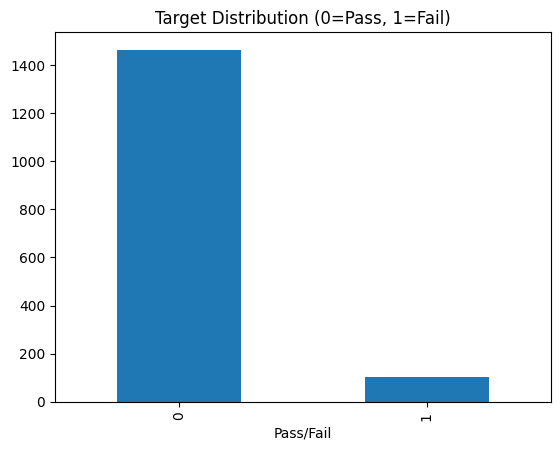

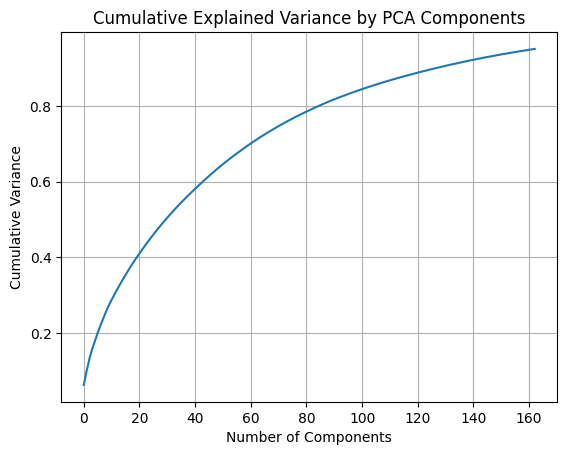

In [12]:
# Target distribution
plt.figure()
y.value_counts().plot(kind='bar')
plt.title('Target Distribution (0=Pass, 1=Fail)')
plt.show()

# PCA variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.show()



## **Conclusion**
In this project, we performed signal classification using machine learning techniques.  
The complete workflow included:
1. Loading and exploring the dataset
2. Data cleaning and preprocessing
3. Feature scaling and dimensionality reduction using PCA
4. Model training using multiple algorithms (Random Forest, SVM, Naive Bayes)
5. Hyperparameter tuning for optimal performance
6. Model evaluation using accuracy, precision, recall, and F1-score
7. Saving the best-performing model and preprocessing pipeline

The final model achieved strong performance, as shown in the evaluation metrics.  
